In [1]:
import pandas as pd 
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
cancer = pd.read_csv(r"C:\Training\Academy\Statistics (Python)\Cases\Wisconsin\BreastCancer.csv",index_col=0)
cancer.head(3)

,Clump,UniCell_Size,Uni_CellShape,MargAdh,SEpith,BareN,BChromatin,NoemN,Mitoses,Class
Code,,,,,,,,,,
61634,5,4,3,1,2,2,2,3,1,Benign
63375,9,1,2,6,4,10,7,7,2,Malignant
76389,10,4,7,2,2,8,6,1,1,Malignant


In [3]:
X = cancer.drop('Class', axis=1)

In [4]:
scaler = StandardScaler().set_output(transform='pandas')
X_scl = scaler.fit_transform(X)
prcomp = PCA().set_output(transform='pandas')
X_pca = prcomp.fit_transform(X_scl)
prcomp.explained_variance_ratio_*100

array([65.45437483,  8.62625123,  5.98724547,  5.13612665,  4.21920122,
        3.39206535,  3.28441735,  2.91485025,  0.98546764])

In [5]:
X.columns

Index(['Clump', 'UniCell_Size', 'Uni_CellShape', 'MargAdh', 'SEpith', 'BareN',
       'BChromatin', 'NoemN', 'Mitoses'],
      dtype='object')

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

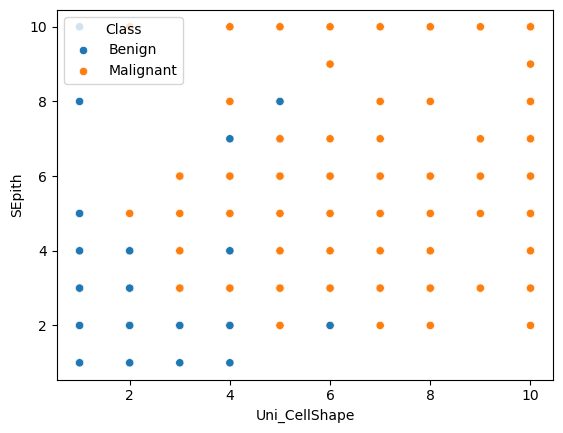

In [7]:
sns.scatterplot(x='Uni_CellShape', y='SEpith', hue='Class', data=cancer)
plt.show()

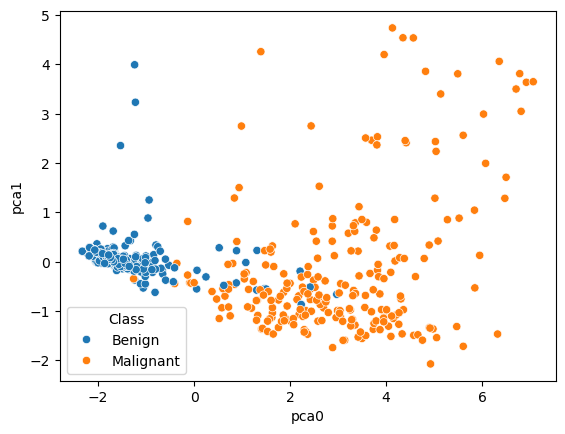

In [8]:
df_pca = X_pca.copy()
df_pca['Class'] = cancer['Class']
sns.scatterplot(x='pca0', y='pca1', hue='Class', data=df_pca)
plt.show()

Usage with **Supervised Learning**

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [11]:
X = cancer.drop('Class', axis=1)
y = cancer['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, test_size=0.3, stratify=y)
lr = LogisticRegression(random_state=24)
prcomp = PCA(n_components=5).set_output(transform='pandas')
pipe_pca = Pipeline([('SCL',scaler),('PCA',prcomp)])
X_trn_pca = pipe_pca.fit_transform(X_train)
lr.fit(X_trn_pca, y_train)
X_tst_pca = pipe_pca.transform(X_test)
y_pred = lr.predict(X_tst_pca)
print(accuracy_score(y_test, y_pred))

0.9761904761904762


### Grid Search CV

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [14]:
scaler, prcomp, lr = StandardScaler(), PCA(), LogisticRegression(random_state=24)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
pipe = Pipeline([('SCL',scaler),('PCA',prcomp),('LR',lr)])
params = {'PCA__n_components':[2,3,4,5,6]}
gcv = GridSearchCV(pipe, param_grid=params, cv=kfold, scoring='roc_auc')
gcv.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('SCL', StandardScaler()),
                                       ('PCA', PCA()),
                                       ('LR',
                                        LogisticRegression(random_state=24))]),
             param_grid={'PCA__n_components': [2, 3, 4, 5, 6]},
             scoring='roc_auc')

In [15]:
print(gcv.best_params_)
print(gcv.best_score_)

{'PCA__n_components': 6}
0.9949406590156368


## Linear Discriminant Transformation

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score

In [18]:
lda = LinearDiscriminantAnalysis()
pipe_lda = Pipeline([('LDA',lda),('LR',lr)])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, test_size=0.3, stratify=y)
pipe_lda.fit(X_train, y_train)
y_pred = pipe_lda.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9619047619047619


In [20]:
y_pred_prob = pipe_lda.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred_prob))

0.995269726247987


### Grid Search

In [22]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
pipe_lda = Pipeline([('LDA',lda),('LR',lr)])
params = {}
gcv = GridSearchCV(pipe_lda, param_grid=params, cv=kfold, scoring='roc_auc')
gcv.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('LDA', LinearDiscriminantAnalysis()),
                                       ('LR',
                                        LogisticRegression(random_state=24))]),
             param_grid={}, scoring='roc_auc')

In [23]:
print(gcv.best_score_)

0.9945307446915699


In [24]:
from sklearn.model_selection import cross_val_score
results = cross_val_score(pipe_lda, X, y, scoring='roc_auc', cv=kfold)
results.mean()

0.9945307446915699